In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import os, shutil
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.preprocessing import image
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
!apt install unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
!unzip "/content/drive/MyDrive/asl_data.zip"

Streaming output truncated to the last 5000 lines.
  inflating: ASL/Z/Z28.jpg           
  inflating: ASL/Z/Z280.jpg          
  inflating: ASL/Z/Z2800.jpg         
  inflating: ASL/Z/Z2801.jpg         
  inflating: ASL/Z/Z2802.jpg         
  inflating: ASL/Z/Z2803.jpg         
  inflating: ASL/Z/Z2804.jpg         
  inflating: ASL/Z/Z2805.jpg         
  inflating: ASL/Z/Z2806.jpg         
  inflating: ASL/Z/Z2807.jpg         
  inflating: ASL/Z/Z2808.jpg         
  inflating: ASL/Z/Z2809.jpg         
  inflating: ASL/Z/Z281.jpg          
  inflating: ASL/Z/Z2810.jpg         
  inflating: ASL/Z/Z2811.jpg         
  inflating: ASL/Z/Z2812.jpg         
  inflating: ASL/Z/Z2813.jpg         
  inflating: ASL/Z/Z2814.jpg         
  inflating: ASL/Z/Z2815.jpg         
  inflating: ASL/Z/Z2816.jpg         
  inflating: ASL/Z/Z2817.jpg         
  inflating: ASL/Z/Z2818.jpg         
  inflating: ASL/Z/Z2819.jpg         
  inflating: ASL/Z/Z282.jpg          
  inflating: ASL/Z/Z2820.jpg         

In [ ]:
train_path = '/content/ASL'

In [ ]:
image_categories = os.listdir(train_path)

FileNotFoundError: ignored

In [ ]:
datagen = ImageDataGenerator(rescale=1/255.,
                                  horizontal_flip=True,
                                  shear_range=0.2,
                                  samplewise_std_normalization=True,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  fill_mode='nearest',
                                  validation_split=0.1)


train = datagen.flow_from_directory(train_path,
                                         batch_size=32,
                                         target_size=(200,200),
                                         class_mode='categorical',
                                         shuffle=True,
                                         interpolation='nearest')

Found 203000 images belonging to 51 classes.


In [ ]:
val = datagen.flow_from_directory(train_path, 
                                                   target_size=(200, 200), 
                                                   shuffle=True, 
                                                   class_mode='categorical', 
                                                   batch_size=64, 
                                                   subset="validation")

Found 20300 images belonging to 51 classes.


In [ ]:
class_map = dict([(v, k) for k, v in train.class_indices.items()])
print(class_map)

{0: '1', 1: '3', 2: '4', 3: '5', 4: '7', 5: '8', 6: '9', 7: 'A', 8: 'B', 9: 'Baby', 10: 'Brother', 11: 'C', 12: 'D', 13: 'Dont_like', 14: 'E', 15: 'F', 16: 'Friend', 17: 'G', 18: 'H', 19: 'Help', 20: 'House', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'Like', 26: 'Love', 27: 'M', 28: 'Make', 29: 'More', 30: 'N', 31: 'Name', 32: 'No', 33: 'O_OR_0', 34: 'P', 35: 'Pay', 36: 'Play', 37: 'Q', 38: 'R', 39: 'S', 40: 'Stop', 41: 'T', 42: 'U', 43: 'V_OR_2', 44: 'W_OR_6', 45: 'With', 46: 'X', 47: 'Y', 48: 'Yes', 49: 'Z', 50: 'nothing'}


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (200, 200, 3), include_top = False, weights = 'imagenet')

In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 99, 99, 32)   864         ['input_3[0][0]']                
                                                                                                  
 batch_normalization_188 (Batch  (None, 99, 99, 32)  96          ['conv2d_188[0][0]']             
 Normalization)                                                                                   
                                                                                       

In [ ]:
inception_output_layer = base_model.get_layer('mixed7')
print('Inception model output shape:', inception_output_layer.output_shape)

inception_output = base_model.output

Inception model output shape: (None, 10, 10, 768)


In [ ]:
from tensorflow.keras.optimizers import RMSprop
from keras import models, layers, optimizers

# x = layers.Flatten()(base_model.output)

x = layers.GlobalAveragePooling2D()(inception_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(51, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc',patience=5,mode='max',verbose=1,min_lr=0.001,factor=0.1)
model_checkpoint = ModelCheckpoint('checkpoint/',monitor='val_acc',mode='max',save_best_only=True,verbose=1)
early_stopping = EarlyStopping(monitor='val_acc',mode='max',verbose=1,patience=90)

hist = model.fit_generator(train,
          #  epochs=10,
          #  batch_size=32,
           steps_per_epoch = 50, 
           validation_steps=50,
           epochs = 100,
           validation_data=val,
           callbacks=[reduce_lr,model_checkpoint,early_stopping])

Epoch 1/100
50/50 [==============================] - ETA: 0s - loss: 3.2163 - acc: 0.0844
Epoch 1: val_acc improved from -inf to 0.04094, saving model to checkpoint/


50/50 [==============================] - 91s 2s/step - loss: 3.2163 - acc: 0.0844 - val_loss: 6.3505 - val_acc: 0.0409 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 3.0185 - acc: 0.1175
Epoch 2: val_acc did not improve from 0.04094
50/50 [==============================] - 62s 1s/step - loss: 3.0185 - acc: 0.1175 - val_loss: 8.1932 - val_acc: 0.0362 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 2.8465 - acc: 0.1406
Epoch 3: val_acc improved from 0.04094 to 0.22875, saving model to checkpoint/


50/50 [==============================] - 97s 2s/step - loss: 2.8465 - acc: 0.1406 - val_loss: 3.2419 - val_acc: 0.2288 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - ETA: 0s - loss: 2.5468 - acc: 0.2081
Epoch 4: val_acc did not improve from 0.22875
50/50 [==============================] - 62s 1s/step - loss: 2.5468 - acc: 0.2081 - val_loss: 3.1433 - val_acc: 0.1691 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - ETA: 0s - loss: 2.2639 - acc: 0.3025
Epoch 5: val_acc improved from 0.22875 to 0.31625, saving model to checkpoint/


50/50 [==============================] - 97s 2s/step - loss: 2.2639 - acc: 0.3025 - val_loss: 2.5242 - val_acc: 0.3162 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - ETA: 0s - loss: 2.0041 - acc: 0.3613
Epoch 6: val_acc did not improve from 0.31625
50/50 [==============================] - 55s 1s/step - loss: 2.0041 - acc: 0.3613 - val_loss: 4.2670 - val_acc: 0.2316 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - ETA: 0s - loss: 1.7925 - acc: 0.4281
Epoch 7: val_acc improved from 0.31625 to 0.39031, saving model to checkpoint/


50/50 [==============================] - 95s 2s/step - loss: 1.7925 - acc: 0.4281 - val_loss: 2.3994 - val_acc: 0.3903 - lr: 0.0010
Epoch 8/100
50/50 [==============================] - ETA: 0s - loss: 1.5893 - acc: 0.4756
Epoch 8: val_acc improved from 0.39031 to 0.44063, saving model to checkpoint/


50/50 [==============================] - 95s 2s/step - loss: 1.5893 - acc: 0.4756 - val_loss: 1.8510 - val_acc: 0.4406 - lr: 0.0010
Epoch 9/100
50/50 [==============================] - ETA: 0s - loss: 1.3755 - acc: 0.5462
Epoch 9: val_acc improved from 0.44063 to 0.49125, saving model to checkpoint/


50/50 [==============================] - 95s 2s/step - loss: 1.3755 - acc: 0.5462 - val_loss: 1.8386 - val_acc: 0.4913 - lr: 0.0010
Epoch 10/100
50/50 [==============================] - ETA: 0s - loss: 1.3035 - acc: 0.5675
Epoch 10: val_acc improved from 0.49125 to 0.50781, saving model to checkpoint/


50/50 [==============================] - 97s 2s/step - loss: 1.3035 - acc: 0.5675 - val_loss: 1.6687 - val_acc: 0.5078 - lr: 0.0010
Epoch 11/100
50/50 [==============================] - ETA: 0s - loss: 1.1728 - acc: 0.6162
Epoch 11: val_acc did not improve from 0.50781
50/50 [==============================] - 61s 1s/step - loss: 1.1728 - acc: 0.6162 - val_loss: 4.1225 - val_acc: 0.4056 - lr: 0.0010
Epoch 12/100
50/50 [==============================] - ETA: 0s - loss: 1.0774 - acc: 0.6606
Epoch 12: val_acc improved from 0.50781 to 0.52125, saving model to checkpoint/


50/50 [==============================] - 98s 2s/step - loss: 1.0774 - acc: 0.6606 - val_loss: 1.9616 - val_acc: 0.5213 - lr: 0.0010
Epoch 13/100
50/50 [==============================] - ETA: 0s - loss: 0.9737 - acc: 0.6800
Epoch 13: val_acc improved from 0.52125 to 0.63406, saving model to checkpoint/


50/50 [==============================] - 98s 2s/step - loss: 0.9737 - acc: 0.6800 - val_loss: 1.3415 - val_acc: 0.6341 - lr: 0.0010
Epoch 14/100
50/50 [==============================] - ETA: 0s - loss: 0.9229 - acc: 0.6988
Epoch 14: val_acc did not improve from 0.63406
50/50 [==============================] - 62s 1s/step - loss: 0.9229 - acc: 0.6988 - val_loss: 2.0517 - val_acc: 0.5322 - lr: 0.0010
Epoch 15/100
50/50 [==============================] - ETA: 0s - loss: 0.8487 - acc: 0.7138
Epoch 15: val_acc did not improve from 0.63406
50/50 [==============================] - 62s 1s/step - loss: 0.8487 - acc: 0.7138 - val_loss: 2.4598 - val_acc: 0.5534 - lr: 0.0010
Epoch 16/100
50/50 [==============================] - ETA: 0s - loss: 0.8467 - acc: 0.7344
Epoch 16: val_acc improved from 0.63406 to 0.68156, saving model to checkpoint/


50/50 [==============================] - 95s 2s/step - loss: 0.8467 - acc: 0.7344 - val_loss: 1.1328 - val_acc: 0.6816 - lr: 0.0010
Epoch 17/100
50/50 [==============================] - ETA: 0s - loss: 0.7822 - acc: 0.7500
Epoch 17: val_acc did not improve from 0.68156
50/50 [==============================] - 56s 1s/step - loss: 0.7822 - acc: 0.7500 - val_loss: 1.4762 - val_acc: 0.6513 - lr: 0.0010
Epoch 18/100
50/50 [==============================] - ETA: 0s - loss: 0.7252 - acc: 0.7669
Epoch 18: val_acc did not improve from 0.68156
50/50 [==============================] - 62s 1s/step - loss: 0.7252 - acc: 0.7669 - val_loss: 1.9694 - val_acc: 0.6072 - lr: 0.0010
Epoch 19/100
50/50 [==============================] - ETA: 0s - loss: 0.7137 - acc: 0.7744
Epoch 19: val_acc improved from 0.68156 to 0.69219, saving model to checkpoint/


50/50 [==============================] - 95s 2s/step - loss: 0.7137 - acc: 0.7744 - val_loss: 1.1342 - val_acc: 0.6922 - lr: 0.0010
Epoch 20/100
50/50 [==============================] - ETA: 0s - loss: 0.6573 - acc: 0.8019
Epoch 20: val_acc did not improve from 0.69219
50/50 [==============================] - 54s 1s/step - loss: 0.6573 - acc: 0.8019 - val_loss: 1.1403 - val_acc: 0.6831 - lr: 0.0010
Epoch 21/100
50/50 [==============================] - ETA: 0s - loss: 0.6220 - acc: 0.7981
Epoch 21: val_acc improved from 0.69219 to 0.81125, saving model to checkpoint/


50/50 [==============================] - 96s 2s/step - loss: 0.6220 - acc: 0.7981 - val_loss: 0.7989 - val_acc: 0.8112 - lr: 0.0010
Epoch 22/100
50/50 [==============================] - ETA: 0s - loss: 0.6593 - acc: 0.7900
Epoch 22: val_acc improved from 0.81125 to 0.81875, saving model to checkpoint/


50/50 [==============================] - 96s 2s/step - loss: 0.6593 - acc: 0.7900 - val_loss: 0.5988 - val_acc: 0.8188 - lr: 0.0010
Epoch 23/100
50/50 [==============================] - ETA: 0s - loss: 0.6238 - acc: 0.8031
Epoch 23: val_acc did not improve from 0.81875
50/50 [==============================] - 63s 1s/step - loss: 0.6238 - acc: 0.8031 - val_loss: 0.7833 - val_acc: 0.7784 - lr: 0.0010
Epoch 24/100
50/50 [==============================] - ETA: 0s - loss: 0.5663 - acc: 0.8213
Epoch 24: val_acc did not improve from 0.81875
50/50 [==============================] - 57s 1s/step - loss: 0.5663 - acc: 0.8213 - val_loss: 1.0697 - val_acc: 0.7563 - lr: 0.0010
Epoch 25/100
50/50 [==============================] - ETA: 0s - loss: 0.5683 - acc: 0.8263
Epoch 25: val_acc improved from 0.81875 to 0.84750, saving model to checkpoint/


50/50 [==============================] - 97s 2s/step - loss: 0.5683 - acc: 0.8263 - val_loss: 0.5906 - val_acc: 0.8475 - lr: 0.0010
Epoch 26/100
50/50 [==============================] - ETA: 0s - loss: 0.5849 - acc: 0.8300
Epoch 26: val_acc improved from 0.84750 to 0.85094, saving model to checkpoint/


50/50 [==============================] - 98s 2s/step - loss: 0.5849 - acc: 0.8300 - val_loss: 0.5270 - val_acc: 0.8509 - lr: 0.0010
Epoch 27/100
50/50 [==============================] - ETA: 0s - loss: 0.5215 - acc: 0.8456
Epoch 27: val_acc improved from 0.85094 to 0.86281, saving model to checkpoint/


50/50 [==============================] - 98s 2s/step - loss: 0.5215 - acc: 0.8456 - val_loss: 0.4294 - val_acc: 0.8628 - lr: 0.0010
Epoch 28/100
50/50 [==============================] - ETA: 0s - loss: 0.5001 - acc: 0.8531
Epoch 28: val_acc did not improve from 0.86281
50/50 [==============================] - 61s 1s/step - loss: 0.5001 - acc: 0.8531 - val_loss: 0.6365 - val_acc: 0.8406 - lr: 0.0010
Epoch 29/100
50/50 [==============================] - ETA: 0s - loss: 0.4903 - acc: 0.8419
Epoch 29: val_acc improved from 0.86281 to 0.88937, saving model to checkpoint/


50/50 [==============================] - 91s 2s/step - loss: 0.4903 - acc: 0.8419 - val_loss: 0.4062 - val_acc: 0.8894 - lr: 0.0010
Epoch 30/100
50/50 [==============================] - ETA: 0s - loss: 0.5350 - acc: 0.8313
Epoch 30: val_acc did not improve from 0.88937
50/50 [==============================] - 55s 1s/step - loss: 0.5350 - acc: 0.8313 - val_loss: 0.6007 - val_acc: 0.8309 - lr: 0.0010
Epoch 31/100
50/50 [==============================] - ETA: 0s - loss: 0.4647 - acc: 0.8581
Epoch 31: val_acc did not improve from 0.88937
50/50 [==============================] - 62s 1s/step - loss: 0.4647 - acc: 0.8581 - val_loss: 1.1384 - val_acc: 0.7628 - lr: 0.0010
Epoch 32/100
50/50 [==============================] - ETA: 0s - loss: 0.4304 - acc: 0.8637
Epoch 32: val_acc did not improve from 0.88937
50/50 [==============================] - 55s 1s/step - loss: 0.4304 - acc: 0.8637 - val_loss: 0.5705 - val_acc: 0.8500 - lr: 0.0010
Epoch 33/100
50/50 [==============================] - ETA:

50/50 [==============================] - 88s 2s/step - loss: 0.3129 - acc: 0.9056 - val_loss: 0.3683 - val_acc: 0.8959 - lr: 0.0010
Epoch 46/100
50/50 [==============================] - ETA: 0s - loss: 0.3580 - acc: 0.8869
Epoch 46: val_acc improved from 0.89594 to 0.90438, saving model to checkpoint/


50/50 [==============================] - 97s 2s/step - loss: 0.3580 - acc: 0.8869 - val_loss: 0.2961 - val_acc: 0.9044 - lr: 0.0010
Epoch 47/100
50/50 [==============================] - ETA: 0s - loss: 0.3563 - acc: 0.8969
Epoch 47: val_acc did not improve from 0.90438
50/50 [==============================] - 61s 1s/step - loss: 0.3563 - acc: 0.8969 - val_loss: 0.4209 - val_acc: 0.8988 - lr: 0.0010
Epoch 48/100
50/50 [==============================] - ETA: 0s - loss: 0.3347 - acc: 0.9087
Epoch 48: val_acc did not improve from 0.90438
50/50 [==============================] - 61s 1s/step - loss: 0.3347 - acc: 0.9087 - val_loss: 0.4470 - val_acc: 0.8875 - lr: 0.0010
Epoch 49/100
50/50 [==============================] - ETA: 0s - loss: 0.3503 - acc: 0.8963
Epoch 49: val_acc did not improve from 0.90438
50/50 [==============================] - 61s 1s/step - loss: 0.3503 - acc: 0.8963 - val_loss: 0.4670 - val_acc: 0.8894 - lr: 0.0010
Epoch 50/100
50/50 [==============================] - ETA:

50/50 [==============================] - 88s 2s/step - loss: 0.2776 - acc: 0.9206 - val_loss: 0.3722 - val_acc: 0.9084 - lr: 0.0010
Epoch 51/100
50/50 [==============================] - ETA: 0s - loss: 0.2940 - acc: 0.9150
Epoch 51: val_acc did not improve from 0.90844
50/50 [==============================] - 62s 1s/step - loss: 0.2940 - acc: 0.9150 - val_loss: 0.4533 - val_acc: 0.8847 - lr: 0.0010
Epoch 52/100
50/50 [==============================] - ETA: 0s - loss: 0.3323 - acc: 0.9013
Epoch 52: val_acc did not improve from 0.90844
50/50 [==============================] - 62s 1s/step - loss: 0.3323 - acc: 0.9013 - val_loss: 0.4099 - val_acc: 0.8900 - lr: 0.0010
Epoch 53/100
50/50 [==============================] - ETA: 0s - loss: 0.2741 - acc: 0.9194
Epoch 53: val_acc did not improve from 0.90844
50/50 [==============================] - 61s 1s/step - loss: 0.2741 - acc: 0.9194 - val_loss: 0.7604 - val_acc: 0.8359 - lr: 0.0010
Epoch 54/100
50/50 [==============================] - ETA:

50/50 [==============================] - 96s 2s/step - loss: 0.2506 - acc: 0.9256 - val_loss: 0.2477 - val_acc: 0.9253 - lr: 0.0010
Epoch 57/100
50/50 [==============================] - ETA: 0s - loss: 0.2439 - acc: 0.9225
Epoch 57: val_acc did not improve from 0.92531
50/50 [==============================] - 61s 1s/step - loss: 0.2439 - acc: 0.9225 - val_loss: 0.6966 - val_acc: 0.8684 - lr: 0.0010
Epoch 58/100
50/50 [==============================] - ETA: 0s - loss: 0.2749 - acc: 0.9137
Epoch 58: val_acc did not improve from 0.92531
50/50 [==============================] - 62s 1s/step - loss: 0.2749 - acc: 0.9137 - val_loss: 0.4752 - val_acc: 0.8766 - lr: 0.0010
Epoch 59/100
50/50 [==============================] - ETA: 0s - loss: 0.2657 - acc: 0.9144
Epoch 59: val_acc did not improve from 0.92531
50/50 [==============================] - 62s 1s/step - loss: 0.2657 - acc: 0.9144 - val_loss: 0.3719 - val_acc: 0.9009 - lr: 0.0010
Epoch 60/100
50/50 [==============================] - ETA:

50/50 [==============================] - 86s 2s/step - loss: 0.2801 - acc: 0.9206 - val_loss: 0.2360 - val_acc: 0.9316 - lr: 0.0010
Epoch 65/100
50/50 [==============================] - ETA: 0s - loss: 0.2284 - acc: 0.9337
Epoch 65: val_acc did not improve from 0.93156
50/50 [==============================] - 62s 1s/step - loss: 0.2284 - acc: 0.9337 - val_loss: 0.3946 - val_acc: 0.9013 - lr: 0.0010
Epoch 66/100
50/50 [==============================] - ETA: 0s - loss: 0.2686 - acc: 0.9187
Epoch 66: val_acc did not improve from 0.93156
50/50 [==============================] - 54s 1s/step - loss: 0.2686 - acc: 0.9187 - val_loss: 0.3017 - val_acc: 0.9231 - lr: 0.0010
Epoch 67/100
50/50 [==============================] - ETA: 0s - loss: 0.2841 - acc: 0.9294
Epoch 67: val_acc did not improve from 0.93156
50/50 [==============================] - 61s 1s/step - loss: 0.2841 - acc: 0.9294 - val_loss: 0.4666 - val_acc: 0.8900 - lr: 0.0010
Epoch 68/100
50/50 [==============================] - ETA:

50/50 [==============================] - 94s 2s/step - loss: 0.2046 - acc: 0.9369 - val_loss: 0.2252 - val_acc: 0.9409 - lr: 0.0010
Epoch 76/100
50/50 [==============================] - ETA: 0s - loss: 0.1908 - acc: 0.9475
Epoch 76: val_acc did not improve from 0.94094
50/50 [==============================] - 60s 1s/step - loss: 0.1908 - acc: 0.9475 - val_loss: 0.1846 - val_acc: 0.9388 - lr: 0.0010
Epoch 77/100
50/50 [==============================] - ETA: 0s - loss: 0.2275 - acc: 0.9356
Epoch 77: val_acc did not improve from 0.94094
50/50 [==============================] - 53s 1s/step - loss: 0.2275 - acc: 0.9356 - val_loss: 0.1998 - val_acc: 0.9384 - lr: 0.0010
Epoch 78/100
50/50 [==============================] - ETA: 0s - loss: 0.2337 - acc: 0.9319
Epoch 78: val_acc improved from 0.94094 to 0.94500, saving model to checkpoint/


50/50 [==============================] - 93s 2s/step - loss: 0.2337 - acc: 0.9319 - val_loss: 0.1917 - val_acc: 0.9450 - lr: 0.0010
Epoch 79/100
50/50 [==============================] - ETA: 0s - loss: 0.1990 - acc: 0.9388
Epoch 79: val_acc did not improve from 0.94500
50/50 [==============================] - 54s 1s/step - loss: 0.1990 - acc: 0.9388 - val_loss: 0.3871 - val_acc: 0.9078 - lr: 0.0010
Epoch 80/100
50/50 [==============================] - ETA: 0s - loss: 0.2179 - acc: 0.9406
Epoch 80: val_acc did not improve from 0.94500
50/50 [==============================] - 60s 1s/step - loss: 0.2179 - acc: 0.9406 - val_loss: 0.3242 - val_acc: 0.9256 - lr: 0.0010
Epoch 81/100
50/50 [==============================] - ETA: 0s - loss: 0.2173 - acc: 0.9362
Epoch 81: val_acc did not improve from 0.94500
50/50 [==============================] - 61s 1s/step - loss: 0.2173 - acc: 0.9362 - val_loss: 0.2127 - val_acc: 0.9388 - lr: 0.0010
Epoch 82/100
50/50 [==============================] - ETA:

50/50 [==============================] - 93s 2s/step - loss: 0.1982 - acc: 0.9444 - val_loss: 0.1721 - val_acc: 0.9472 - lr: 0.0010
Epoch 94/100
50/50 [==============================] - ETA: 0s - loss: 0.1951 - acc: 0.9475
Epoch 94: val_acc improved from 0.94719 to 0.95000, saving model to checkpoint/


50/50 [==============================] - 94s 2s/step - loss: 0.1951 - acc: 0.9475 - val_loss: 0.1310 - val_acc: 0.9500 - lr: 0.0010
Epoch 95/100
50/50 [==============================] - ETA: 0s - loss: 0.1768 - acc: 0.9525
Epoch 95: val_acc did not improve from 0.95000
50/50 [==============================] - 62s 1s/step - loss: 0.1768 - acc: 0.9525 - val_loss: 0.2286 - val_acc: 0.9209 - lr: 0.0010
Epoch 96/100
50/50 [==============================] - ETA: 0s - loss: 0.2051 - acc: 0.9456
Epoch 96: val_acc did not improve from 0.95000
50/50 [==============================] - 62s 1s/step - loss: 0.2051 - acc: 0.9456 - val_loss: 0.2321 - val_acc: 0.9316 - lr: 0.0010
Epoch 97/100
50/50 [==============================] - ETA: 0s - loss: 0.1635 - acc: 0.9500
Epoch 97: val_acc did not improve from 0.95000
50/50 [==============================] - 62s 1s/step - loss: 0.1635 - acc: 0.9500 - val_loss: 0.2122 - val_acc: 0.9241 - lr: 0.0010
Epoch 98/100
50/50 [==============================] - ETA:

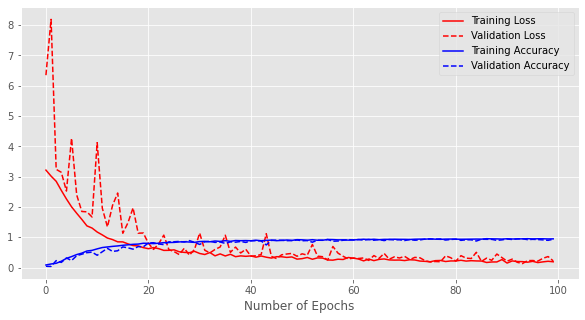

In [ ]:
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['acc'], c='blue', label='Training Accuracy')
plt.plot(h['val_acc'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/model_inc.h5')

In [ ]:
model = load_model("/content/drive/MyDrive/sign_lang/model_inc.h5")

In [ ]:
model.evaluate(val)

311/318 [============================>.] - ETA: 5s - loss: 0.2091 - acc: 0.9371

In [ ]:
class_map = {0: '1', 1: '3', 2: '4', 3: '5', 4: '7', 5: '8', 6: '9', 7: 'A', 8: 'B', 9: 'Baby', 10: 'Brother', 11: 'C', 12: 'D', 13: 'Dont_like', 14: 'E', 15: 'F', 16: 'Friend', 17: 'G', 18: 'H', 19: 'Help', 20: 'House', 21: 'I', 22: 'J', 23: 'K', 24: 'L', 25: 'Like', 26: 'Love', 27: 'M', 28: 'Make', 29: 'More', 30: 'N', 31: 'Name', 32: 'No', 33: 'O_OR_0', 34: 'P', 35: 'Pay', 36: 'Play', 37: 'Q', 38: 'R', 39: 'S', 40: 'Stop', 41: 'T', 42: 'U', 43: 'V_OR_2', 44: 'W_OR_6', 45: 'With', 46: 'X', 47: 'Y', 48: 'Yes', 49: 'Z', 50: 'nothing'}

In [ ]:
def generate_predictions(test_image_path, actual_label):
    
    test_img = tf.keras.utils.load_img(test_image_path, target_size=(200, 200))
    test_img_arr = tf.keras.utils.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    predicted_label = np.argmax(model.predict(test_img_input))
    predicted_category = class_map[predicted_label]
    plt.figure(figsize=(5, 5))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_category, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 122ms/step


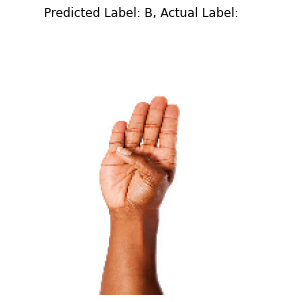

In [ ]:
test_img = '/content/drive/MyDrive/sign_lang/letterb.jpeg'


generate_predictions(test_img, actual_label='')

1/1 [==============================] - 0s 407ms/step


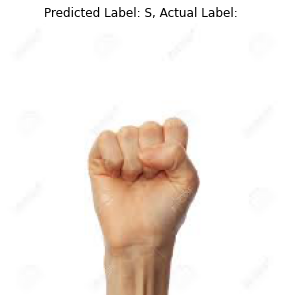

In [ ]:
test_img = '/content/drive/MyDrive/sign_lang/letters.jpeg'


generate_predictions(test_img, actual_label='')